In [1]:
import os
import re
import jieba
import numpy as np
from tqdm import tqdm
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import jieba
%matplotlib inline
import matplotlib
from wordcloud import WordCloud#词云包
tqdm.pandas(desc='apply')
os.getcwd()

'D:\\NLP_elephant\\ProgramCoder\\program8'

In [2]:
#初始化每一子类样本总数量词典
age_subclass_dict = defaultdict(int)
gender_subclass_dict = defaultdict(int)
education_subclass_dict = defaultdict(int)

In [3]:
# 生成每条数据的k-fold 索引k
def genrate_k_fold_index(subclass, subclass_dict: dict, n=5):
    index = subclass_dict[subclass] % n
    subclass_dict[subclass] += 1
    return index


In [4]:
# 使用结巴进行分词，默认非中文连续字符为一个词；词词之间用'\t'拼接，词条之间用'\t\t'拼接；

def matcher(string):
    pattern = re.compile('[^\u4e00-\u9fff ]+')
    return set(re.findall(pattern,string))

def cut_sentences(sentences):
    splits = sentences.split("\t")
    total_words = []
    for sen in splits:
        match_result = matcher(sen)
        if match_result:
            for w in match_result:
                if len(w) == 1:
                    continue
                sen = sen.replace(w, f'\t->{w}\t')
            words = []
            for sub_sen in sen.split('\t'):
                if sub_sen.startswith('->'):
                    words.append(sub_sen[2:])
                    continue
                words.extend(jieba.lcut(sub_sen))
#             print(words)
            total_words.append('\t'.join(words))
            continue
        total_words.append('\t'.join(jieba.lcut(sen)))
    return '\t\t'.join(total_words)
    

In [5]:
#数据读取和词分割、生成k-fold index
def preprocess(file):
    names = ['ID', 'Age', 'Gender', 'Education', 'Query']
    data_dtype = {'ID': np.str, "Age": np.int16, 'Gender': np.int16, 'Education': np.int16, 'Query': np.str}
    df = pd.read_csv(file, sep='###__###', header=None, names=names, dtype=data_dtype, encoding='utf-8',engine='python')
    df['age_kfold_index'] = df['Age'].progress_apply(lambda x: genrate_k_fold_index(x, age_subclass_dict))
    df['gender_kfold_index'] = df['Gender'].progress_apply(lambda x: genrate_k_fold_index(x, gender_subclass_dict))
    df['education_kfold_index'] = df['Education'].progress_apply(
        lambda x: genrate_k_fold_index(x, education_subclass_dict))
    df['Query'] = df['Query'].progress_apply(lambda x: cut_sentences(x))

    newdf = df[df.Age == 1]
    print(newdf[['Age', 'age_kfold_index']].head(10))

    return df
file = './data/train.csv'
data_df = preprocess(file)

apply:   0%|                                                                                | 0/100000 [00:00<?, ?it/s]Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lenovo\AppData\Local\Temp\jieba.cache
Loading model cost 1.291 seconds.
Prefix dict has been built succesfully.
apply: 100%|███████████████████████████████████████████████████████████████████| 100000/100000 [23:49<00:00, 69.96it/s]


    Age  age_kfold_index
0     1                0
8     1                1
9     1                2
10    1                3
11    1                4
14    1                0
16    1                1
17    1                2
21    1                3
22    1                4


In [6]:
#保存处理分词后的数据
data_df = data_df[['ID', 'Age', 'Gender', 'Education','age_kfold_index','gender_kfold_index','education_kfold_index', 'Query']]

data_df.to_csv('./data/preprocessed.csv',sep=str(","),header=None,index=False,encoding='utf-8')

In [8]:
#重新载入数据
names = ['ID', 'Age', 'Gender', 'Education','age_kfold_index','gender_kfold_index','education_kfold_index', 'Query']
data_df= pd.read_csv('./data/preprocessed.csv',sep=',',header=None,names=names)
data_df.head(10)

,ID,Age,Gender,Education,age_kfold_index,gender_kfold_index,education_kfold_index,Query
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,0,0,0,柔和\t双沟\t\t女生\t\t中财网\t首页\t \t财经\t\thttp://pan.b...
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,0,1,0,"广州\t厨宝\t烤箱\t\t世情\t薄\t,\t人情\t恶\t,\t雨送\t黄昏\t花易落\..."
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,0,2,0,钻石\t之泪\t耳机\t\t盘锦\t到\t沈阳\t\t旅顺\t公交\t\t辽宁\t阜新\t车...
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,1,0,1,最\t受欢迎\t狗狗\t排行榜\t\t舶\t怎么\t读\t\t场景\t描\t \t写\t范例...
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,1,1,1,干槽症\t能\t自愈\t吗\t\t太太\t万岁\t叶\t舒心\t去\t没\t去\t美国\t\...
5,5BB424C7298B2CB67C368DDB73D4D336,4,2,0,2,2,1,钢琴曲\t欣赏\t100\t首\t\t一个月\t的\t宝宝\t眼睫毛\t那么\t是\t黄色\...
6,0D58894CD481D4B3039000661665C0DB,3,2,3,0,3,2,貔貅\t饲育\t指南\t\t韩姨\t\t贵阳\t学\t古琴\t\t洛基\t\t风速\t狗\t...
7,0BA56489237BC91353300BE44298C6D8,6,1,0,0,3,2,昂\t的\t笔顺\t\t三年级\t上册\t数学\t口\t算\t\t牛\t的\t英语\t怎么\...
8,3D39C1B9312105E030B039CCDCD79611,1,1,5,1,4,0,李明霖\t在\t哪\t直播\t\t英文翻译\t\t薄荷\t籽\t\t为什么\t搜狐\t视频\...
9,93174489E2E708BF6F797DC69F1531A8,1,1,5,2,0,1,bft20\t\t龙王\t传说\t\t长治\t到\t成都\t可以\t怎么\t坐火车\t\t龙...


In [33]:
# 统计词出现的频数
def count_seg(Query,stopwords=None):
    segs_freq = defaultdict(int)
    if stopwords is None:
        stopwords =set()
    if not isinstance(stopwords,set):
        stopwords=set(stopwords)
    for sentences in Query:
        for sen in sentences.split('\t\t'):
            for w in sen.split("\t"):
                if w in stopwords:
                    continue
                segs_freq[w]+=1
    sges_freq_sorted = _sorted_seg(segs_freq)
    
    
    return sges_freq_sorted
# 排序
def _sorted_seg(segs:dict):
    return sorted(segs.items(),key=lambda x: x[1],reverse=True)
#加载停用词
stopwords = pd.read_csv('./data/stopwords.txt',sep='\t',header=None,names=['stopword'],
                        quoting=3,encoding='utf-8',engine='python')

words_stat = count_seg(data_df.Query.values,stopwords=stopwords.stopword.values)
print(words_stat[:10])


# def save_vocab(file,vocab):
#     w= open(file,'w',encoding='utf-8')
#     for key,value in vocab:
# #         if value<2:
# #             continue
#         w.write(f'{key}\t{value}\n')
#     w.close() 
#     print('completed.....')
# vocab_file='./data/vocab.txt'
# save_vocab(vocab_file,vocab_sorted)
        


[(' ', 488098), ('图片', 291072), ('手机', 191472), ('小说', 159799), ('视频', 157487), ('下载', 134929), ('大全', 131463), ('吃', 128021), ('钱', 103242), ('qq', 98201)]


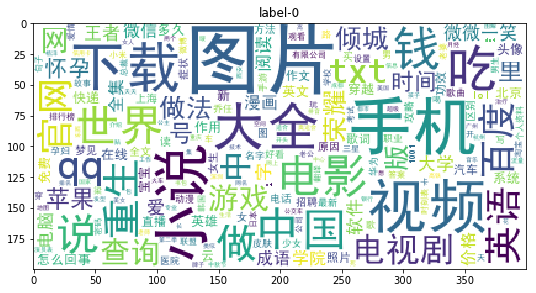

In [68]:
# 词 top_k 可视化
def word_visualize(data_df,top_k=1000,n=1,class_name=None,stopwords= None):
    import math

    if n is None:
        w =1
        h=1
        height = 5
        width = 10
    else:
        h = math.ceil(n/3)
        w = 3
        height = h*5
        width = w*10
        
    fig = plt.figure(figsize=(width,height))
    for i in range(n):
        
        tmp_df = data_df if class_name is None else data_df[data_df[class_name]==int(i)]
        class_stat = count_seg(tmp_df.Query.values,stopwords=stopwords)
        axis = plt.subplot(h,w,i+1)
        matplotlib.rcParams['figure.figsize'] = (10.0, 5.0)
        wordcloud=WordCloud(font_path="./data/simhei.ttf",background_color="white",max_font_size=80)
        word_frequence = {x[0]:x[1] for x in class_stat[:top_k]}
        wordcloud=wordcloud.fit_words(word_frequence)
        plt.imshow(wordcloud)
        axis.set_title(f'label-{i}')
    plt.show()
    
word_visualize(data_df,stopwords=stopwords.stopword)

In [39]:
#Age 分类 
Age_df = data_df.groupby("Age").agg('count')
Age_df

,ID,Gender,Education,age_kfold_index,gender_kfold_index,education_kfold_index,Query
Age,,,,,,,
0,1666,1666,1666,1666,1666,1666,1666
1,38996,38996,38996,38996,38996,38996,38996
2,26744,26744,26744,26744,26744,26744,26744
3,18529,18529,18529,18529,18529,18529,18529
4,10654,10654,10654,10654,10654,10654,10654
5,2922,2922,2922,2922,2922,2922,2922
6,489,489,489,489,489,489,489


###### 数据分布不均匀 ，5,6 类数据量过少

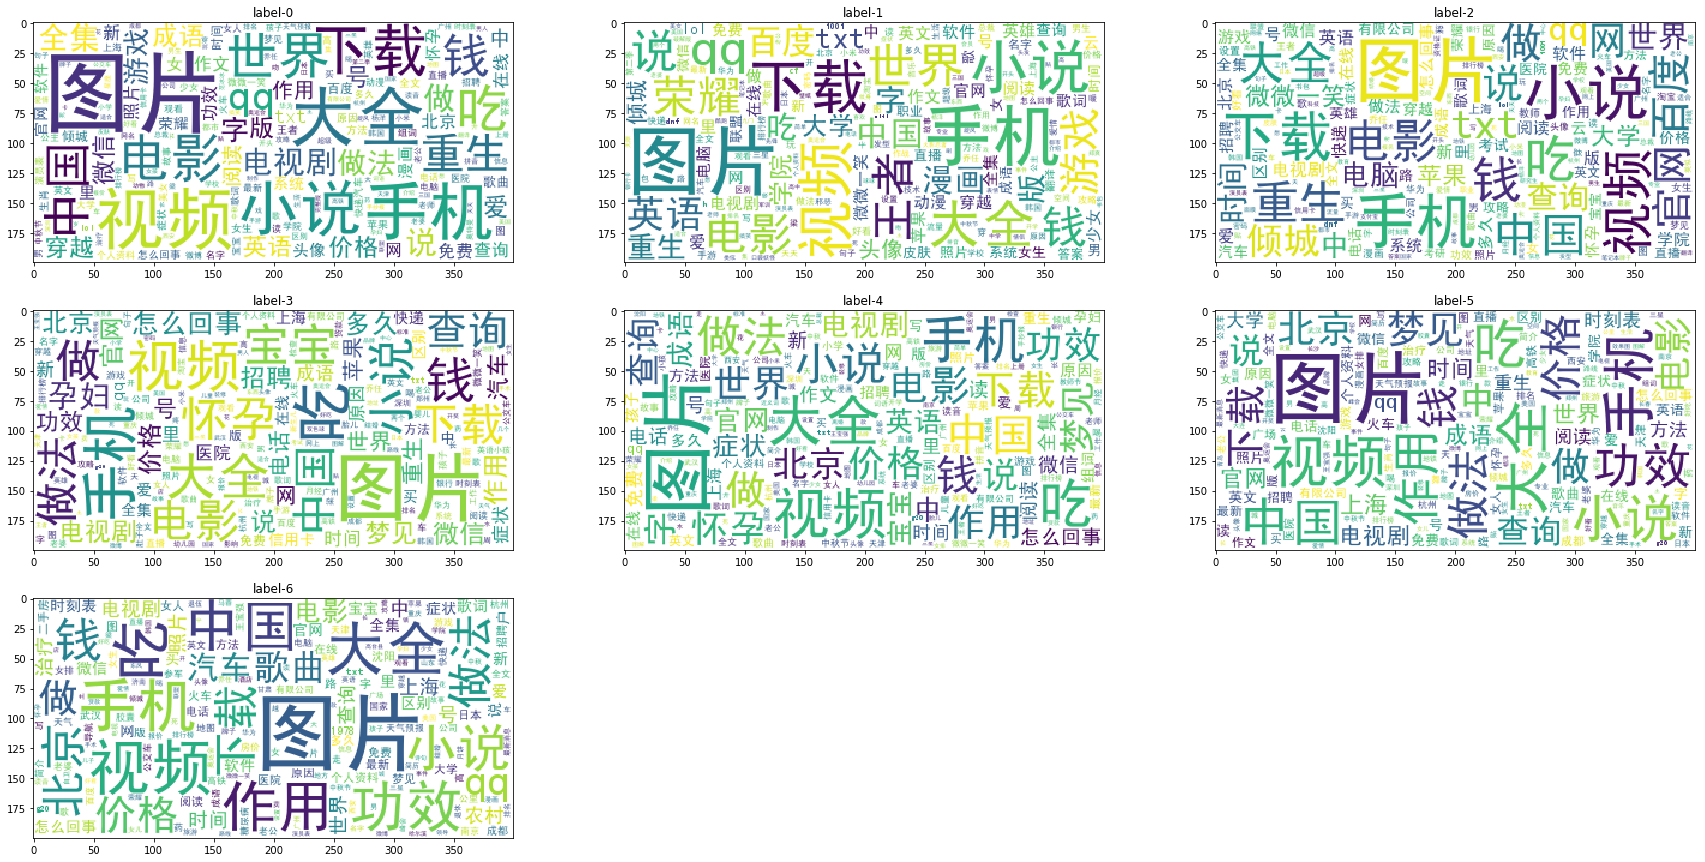

In [69]:
word_visualize(data_df,n=7,class_name='Age',stopwords=stopwords.stopword)

In [71]:
# Gender
gender_df = data_df.groupby("Gender").agg('count')
gender_df

,ID,Age,Education,age_kfold_index,gender_kfold_index,education_kfold_index,Query
Gender,,,,,,,
0,2155,2155,2155,2155,2155,2155,2155
1,56976,56976,56976,56976,56976,56976,56976
2,40869,40869,40869,40869,40869,40869,40869


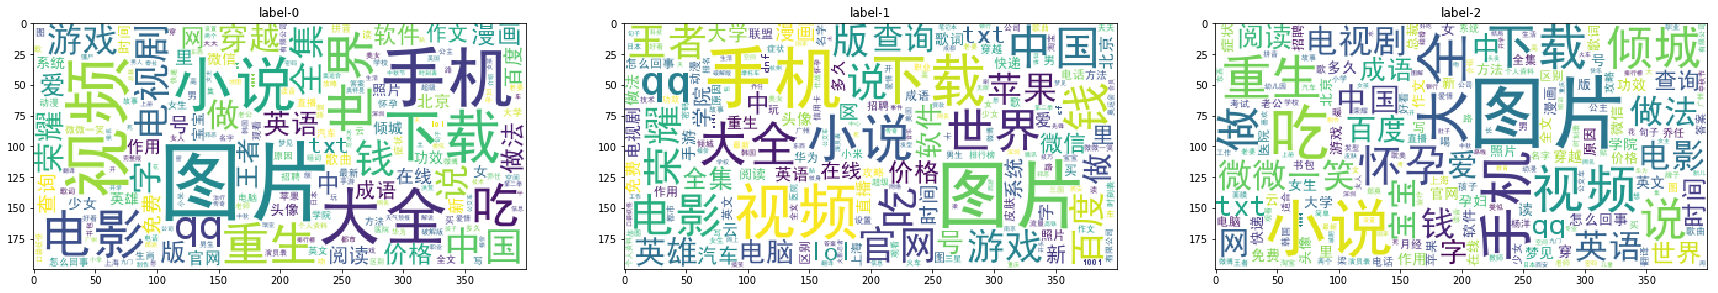

In [72]:
word_visualize(data_df=data_df,n=3,class_name='Gender',stopwords=stopwords.stopword)

In [74]:
#Education
education_df = data_df.groupby('Education').agg("count")
education_df

,ID,Age,Gender,age_kfold_index,gender_kfold_index,education_kfold_index,Query
Education,,,,,,,
0,9280,9280,9280,9280,9280,9280,9280
1,354,354,354,354,354,354,354
2,560,560,560,560,560,560,560
3,18858,18858,18858,18858,18858,18858,18858
4,28148,28148,28148,28148,28148,28148,28148
5,37107,37107,37107,37107,37107,37107,37107
6,5693,5693,5693,5693,5693,5693,5693


#####  数据分布不均，1，2,6 数据量少 
##### 词频可视化上没看出明显区别

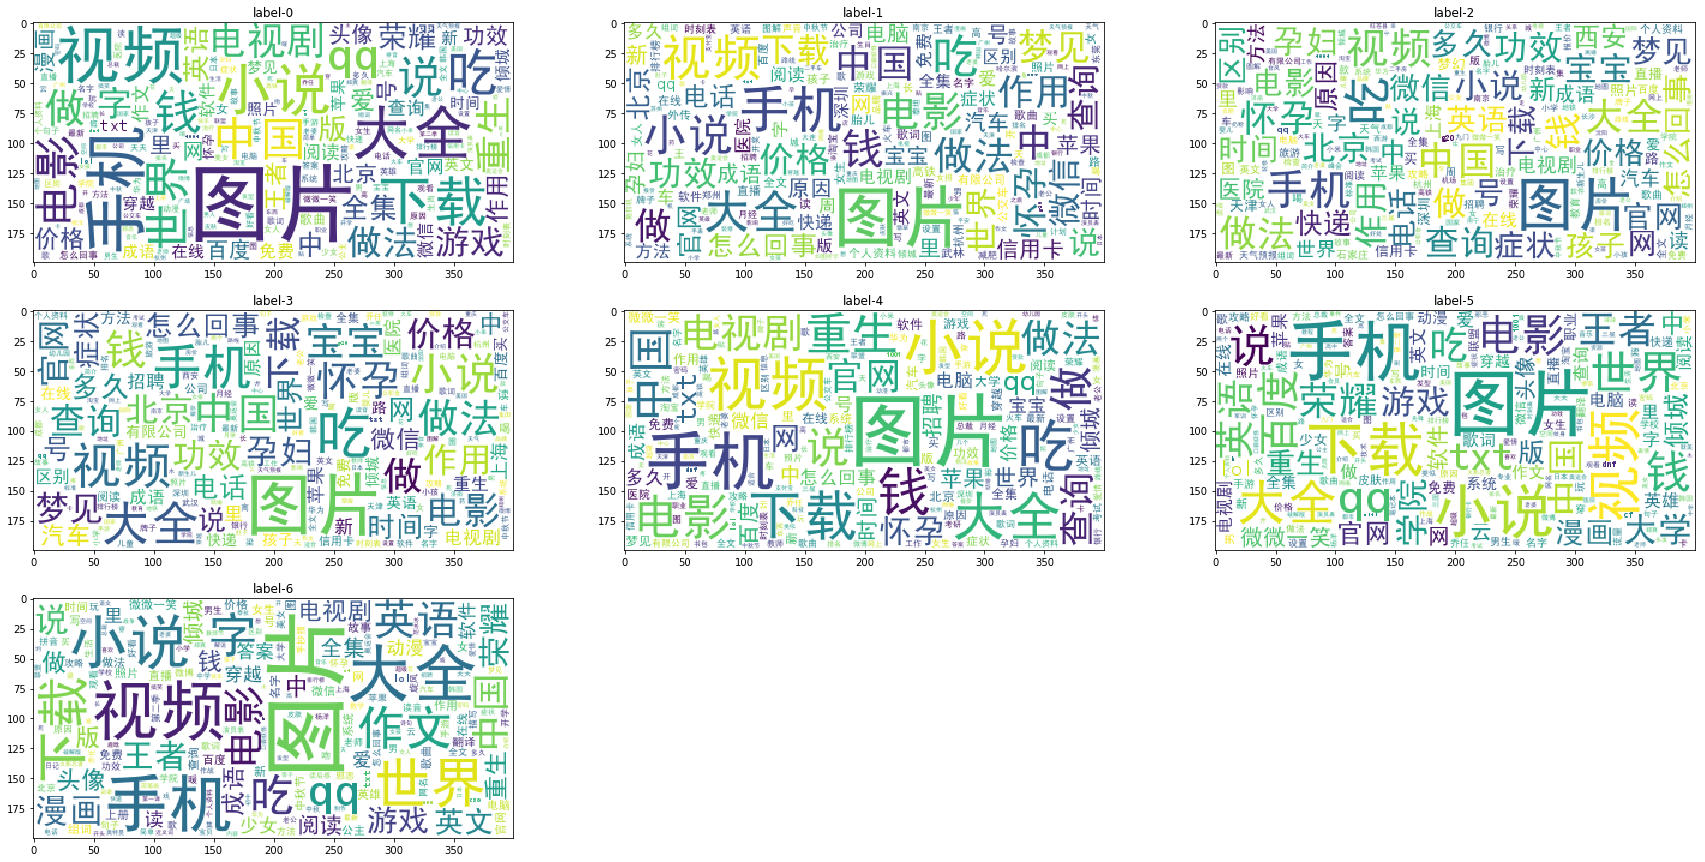

In [76]:
word_visualize(data_df=data_df,n=7,class_name='Education',stopwords=stopwords.stopword)

##### 利用 query 构建特征
* 搜索词条的数量
* 词条的平均长度、最大长度、最小长度
* 词条包含空格的比率
* 词条包含字母的比率
* more .....

(未去除特殊字符)

In [5]:

def is_contain_letter(str0):
    import re
    return bool(re.search('[a-zA-Z]', str0))
# 特征提取
def query_stat(querys):
    query_splits = querys.split('\t\t')
    # Query的数量
    query_num = len(query_splits)
    # Query的平均长度
    query_ave_length = 0
    # Query的最大长度
    query_max_length = 0
    # Query的最小长度
    query_min_length = 1000
    # 空格率
    blank_rate = 0
    # 字母率
    english_rate = 0

    for single_query in query_splits:
        single_query = single_query.replace('\t', '')
        query_length = len(single_query)
        query_max_length = query_length if query_length > query_max_length else query_max_length
        query_min_length = query_length if query_length < query_min_length else query_min_length
        query_ave_length += query_length
        if " " in single_query:
            blank_rate += 1
        if is_contain_letter(single_query):
            english_rate += 1
#         print(query_length)

    query_ave_length /= query_num
    blank_rate /= query_num
    english_rate /= query_num
    stat_list = [query_num, query_max_length, query_ave_length, query_min_length, blank_rate, english_rate]

    return stat_list

def extract_feat(file):
    names = ['ID', 'Age', 'Gender', 'Education', 'age_kfold_index', 'gender_kfold_index', 'education_kfold_index',
             'Query']

    data_df = pd.read_csv(file, sep=',', header=None, names=names)
    data_df['query_stat'] = data_df['Query'].progress_apply(lambda x: query_stat(x))
    data_df['query_num'] = data_df['query_stat'].progress_apply(lambda x: x[0])
    data_df['query_max_len'] = data_df['query_stat'].progress_apply(lambda x: x[1])
    data_df['query_ave_len'] = data_df['query_stat'].progress_apply(lambda x: x[2])
    data_df['query_min_len'] = data_df['query_stat'].progress_apply(lambda x: x[3])
    data_df['blank_rate'] = data_df['query_stat'].progress_apply(lambda x: x[4])
    data_df['english_rate'] = data_df['query_stat'].progress_apply(lambda x: x[5])
    return data_df

In [6]:
preporcess_file = './data/preprocessed.csv'
data_df = extract_feat(preporcess_file)

apply: 100%|███████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 400219.08it/s]


In [7]:
data_df.head(10)

,ID,Age,Gender,Education,age_kfold_index,gender_kfold_index,education_kfold_index,Query,query_stat,query_num,query_max_len,query_ave_len,query_min_len,blank_rate,english_rate
0,22DD920316420BE2DF8D6EE651BA174B,1,1,4,0,0,0,柔和\t双沟\t\t女生\t\t中财网\t首页\t \t财经\t\thttp://pan.b...,"[275, 40, 8.654545454545454, 1, 0.029090909090...",275,40,8.654545,1,0.029091,0.105455
1,43CC3AF5A8D6430A3B572337A889AFE4,2,1,3,0,1,0,"广州\t厨宝\t烤箱\t\t世情\t薄\t,\t人情\t恶\t,\t雨送\t黄昏\t花易落\...","[186, 28, 8.838709677419354, 2, 0.059139784946...",186,28,8.838710,2,0.059140,0.053763
2,E97654BFF5570E2CCD433EA6128EAC19,4,1,0,0,2,0,钻石\t之泪\t耳机\t\t盘锦\t到\t沈阳\t\t旅顺\t公交\t\t辽宁\t阜新\t车...,"[104, 21, 5.740384615384615, 2, 0.019230769230...",104,21,5.740385,2,0.019231,0.125000
3,6931EFC26D229CCFCEA125D3F3C21E57,4,2,3,1,0,1,最\t受欢迎\t狗狗\t排行榜\t\t舶\t怎么\t读\t\t场景\t描\t \t写\t范例...,"[173, 20, 6.502890173410405, 1, 0.017341040462...",173,20,6.502890,1,0.017341,0.034682
4,E780470C3BB0D340334BD08CDCC3C71A,2,2,4,1,1,1,干槽症\t能\t自愈\t吗\t\t太太\t万岁\t叶\t舒心\t去\t没\t去\t美国\t\...,"[117, 20, 8.649572649572649, 2, 0.042735042735...",117,20,8.649573,2,0.042735,0.119658
5,5BB424C7298B2CB67C368DDB73D4D336,4,2,0,2,2,1,钢琴曲\t欣赏\t100\t首\t\t一个月\t的\t宝宝\t眼睫毛\t那么\t是\t黄色\...,"[102, 16, 8.656862745098039, 2, 0.0, 0.0294117...",102,16,8.656863,2,0.000000,0.029412
6,0D58894CD481D4B3039000661665C0DB,3,2,3,0,3,2,貔貅\t饲育\t指南\t\t韩姨\t\t贵阳\t学\t古琴\t\t洛基\t\t风速\t狗\t...,"[107, 14, 5.785046728971962, 2, 0.028037383177...",107,14,5.785047,2,0.028037,0.046729
7,0BA56489237BC91353300BE44298C6D8,6,1,0,0,3,2,昂\t的\t笔顺\t\t三年级\t上册\t数学\t口\t算\t\t牛\t的\t英语\t怎么\...,"[140, 30, 7.5, 1, 0.03571428571428571, 0.02142...",140,30,7.500000,1,0.035714,0.021429
8,3D39C1B9312105E030B039CCDCD79611,1,1,5,1,4,0,李明霖\t在\t哪\t直播\t\t英文翻译\t\t薄荷\t籽\t\t为什么\t搜狐\t视频\...,"[103, 33, 8.912621359223301, 2, 0.029126213592...",103,33,8.912621,2,0.029126,0.087379
9,93174489E2E708BF6F797DC69F1531A8,1,1,5,2,0,1,bft20\t\t龙王\t传说\t\t长治\t到\t成都\t可以\t怎么\t坐火车\t\t龙...,"[89, 14, 7.629213483146067, 2, 0.0337078651685...",89,14,7.629213,2,0.033708,0.146067


##### 特征分布可视化

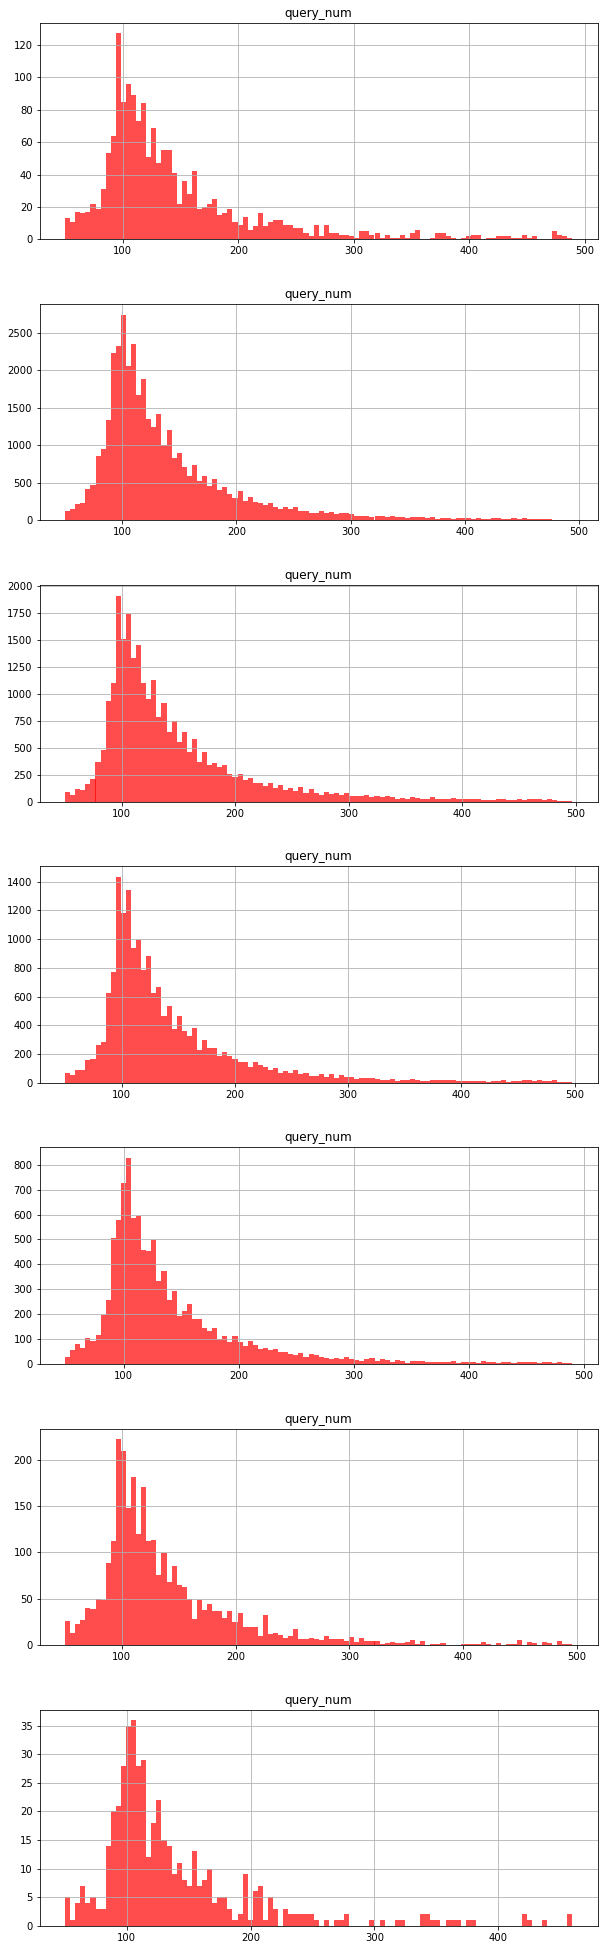

In [19]:
# # fig,axes = plt.subplots(7,1,fig_size(10,35))
# fig =plt.figure(figsize=(10,35))
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Age==i].hist('query_num',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

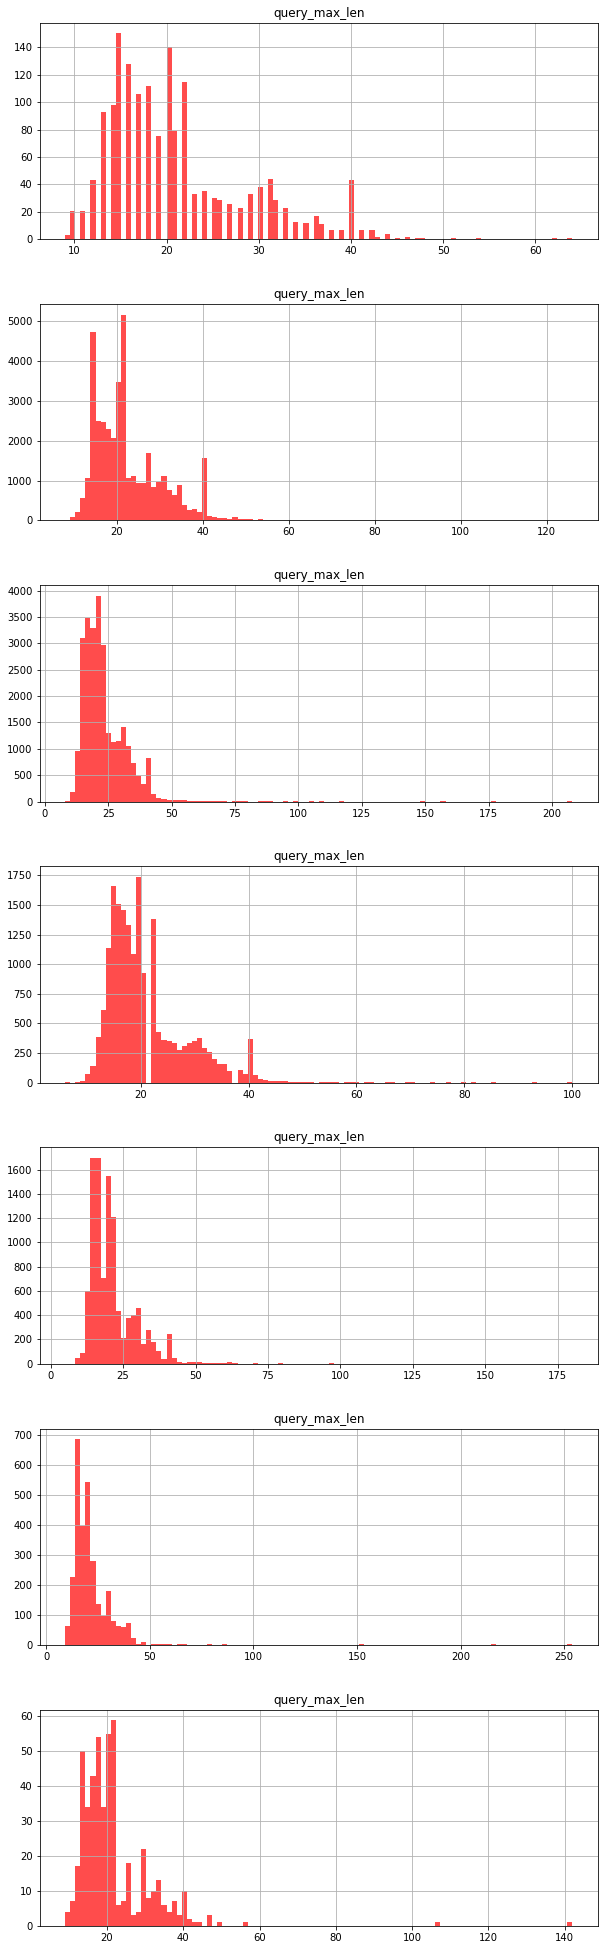

In [20]:
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Age==i].hist('query_max_len',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

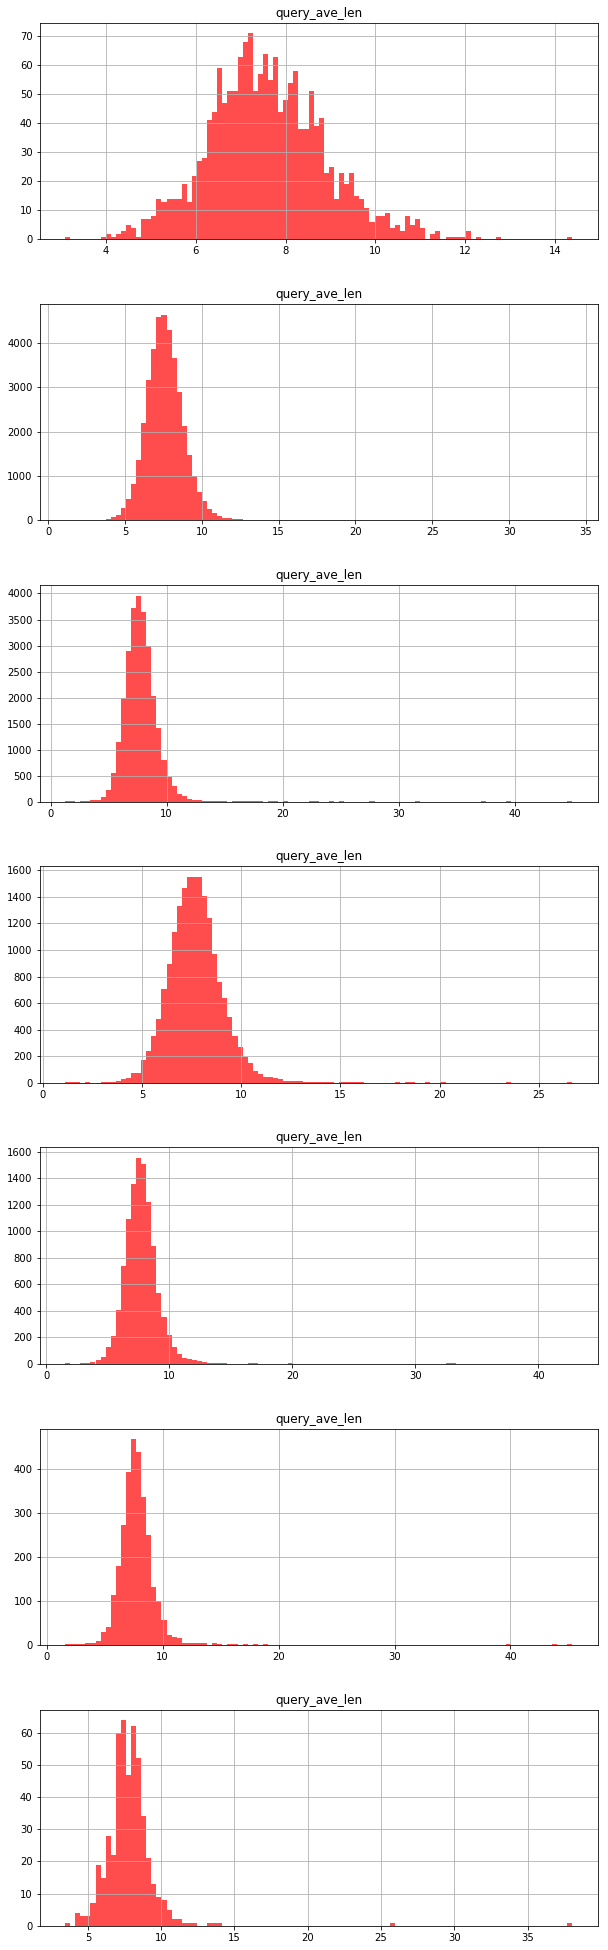

In [21]:
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Age==i].hist('query_ave_len',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

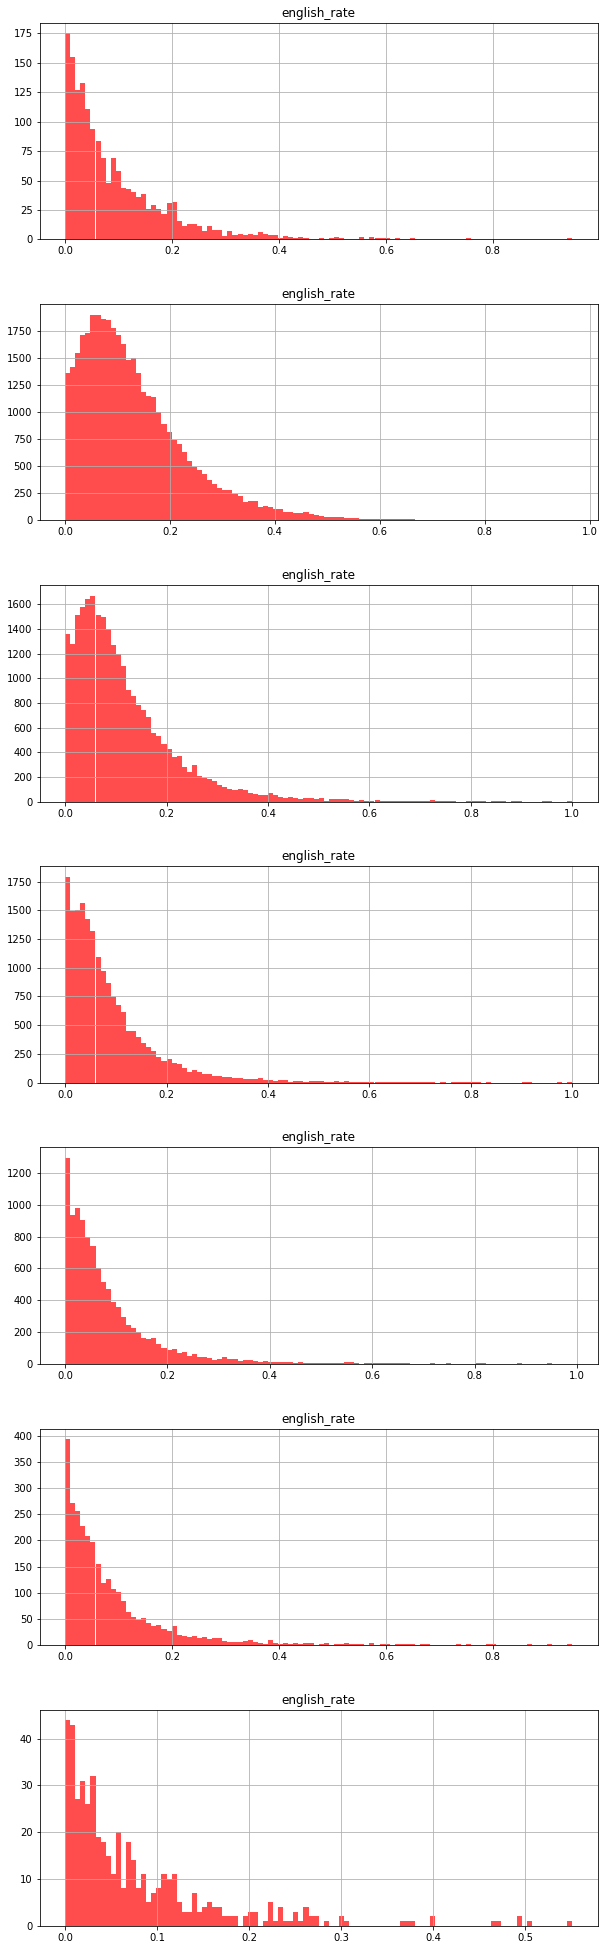

In [22]:
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Age==i].hist('english_rate',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

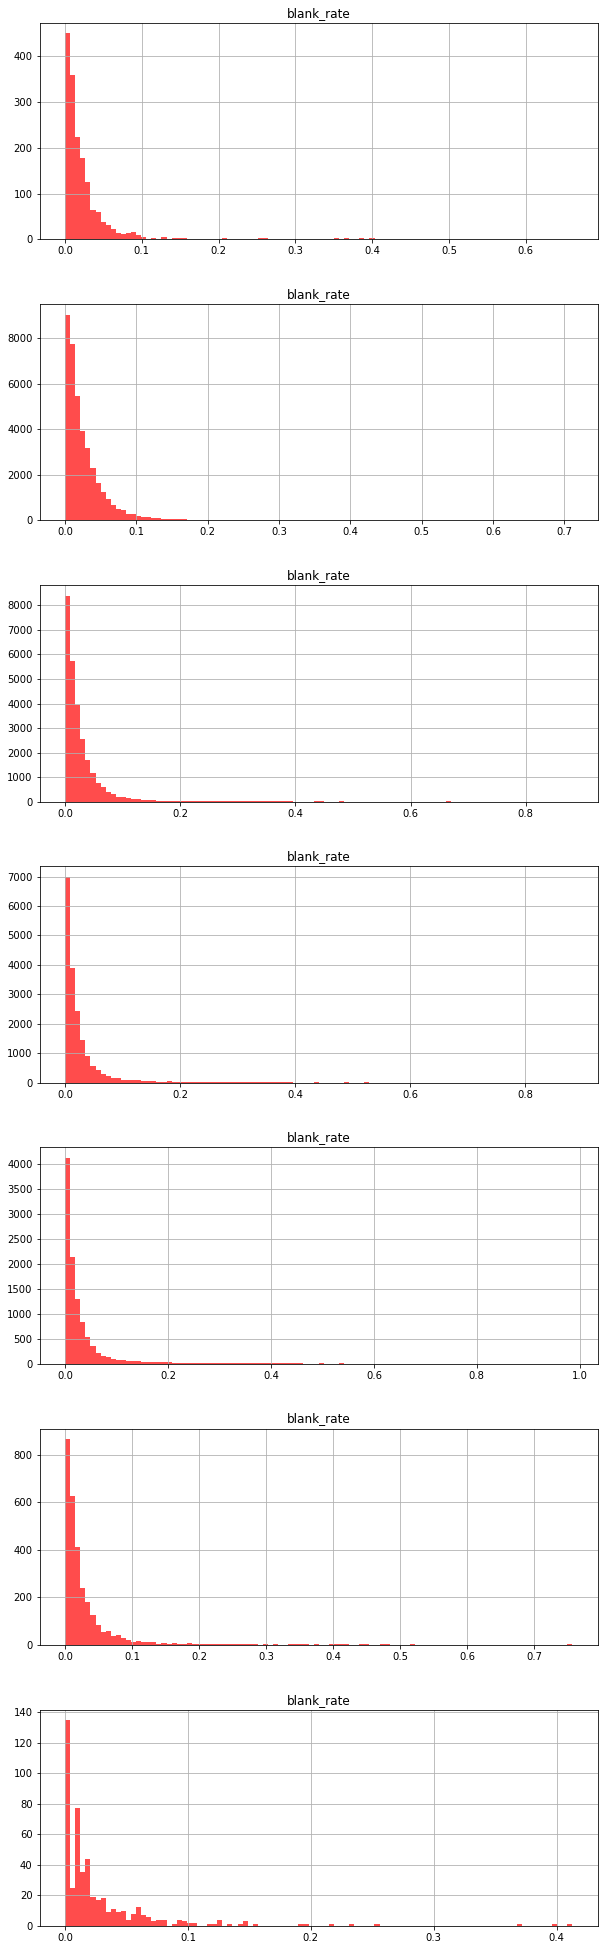

In [23]:
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Age==i].hist('blank_rate',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

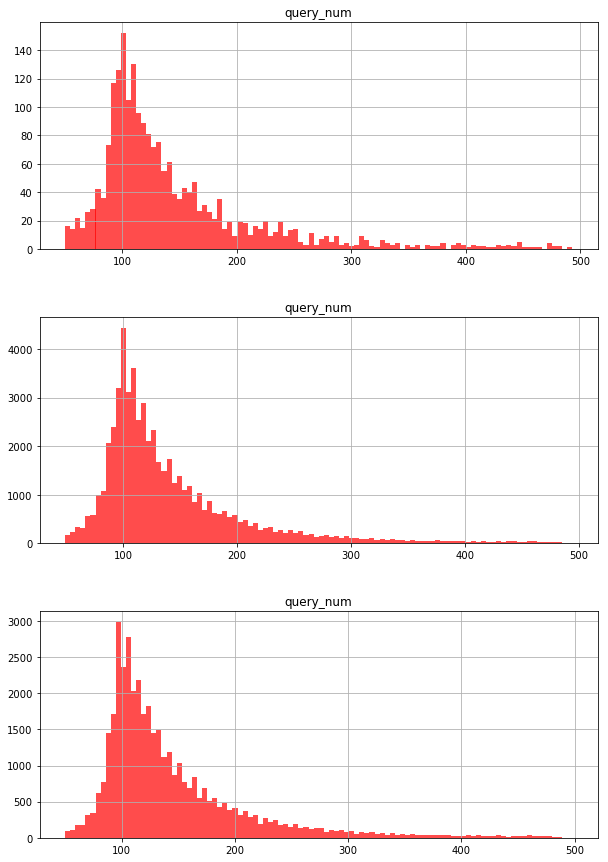

In [24]:
fig,axes = plt.subplots(3,1,figsize=(10,15))
for i in range(3):
    data_df[data_df.Gender==i].hist('query_num',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

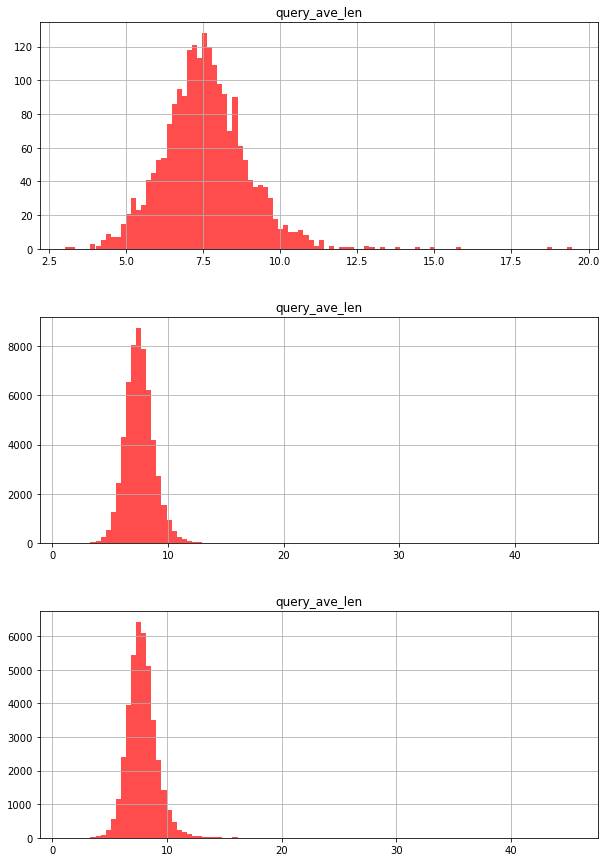

In [25]:
fig,axes = plt.subplots(3,1,figsize=(10,15))
for i in range(3):
    data_df[data_df.Gender==i].hist('query_ave_len',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

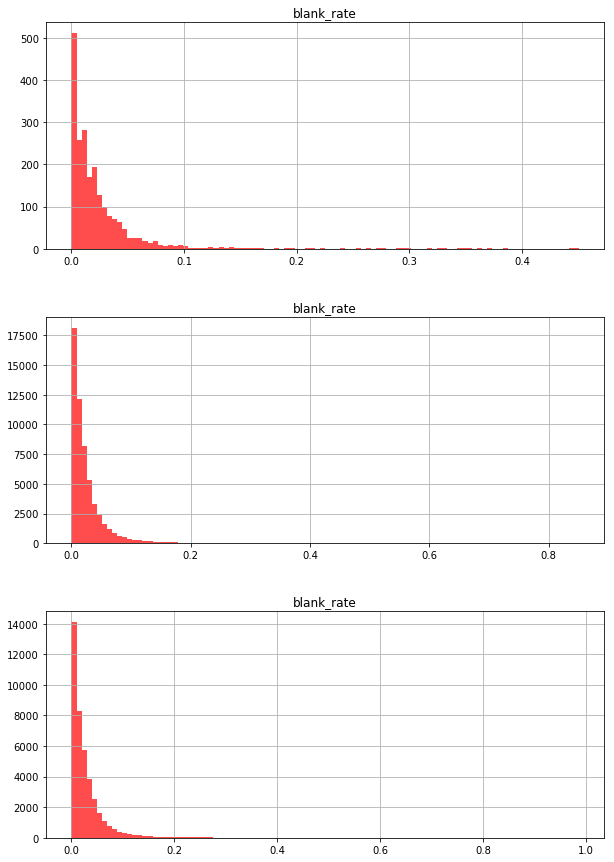

In [26]:
fig,axes = plt.subplots(3,1,figsize=(10,15))
for i in range(3):
    data_df[data_df.Gender==i].hist('blank_rate',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

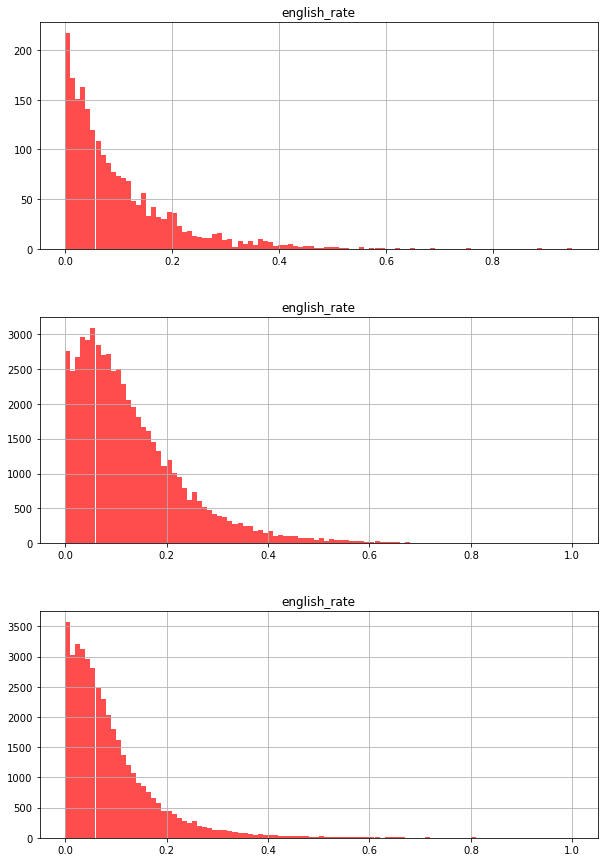

In [27]:
fig,axes = plt.subplots(3,1,figsize=(10,15))
for i in range(3):
    data_df[data_df.Gender==i].hist('english_rate',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

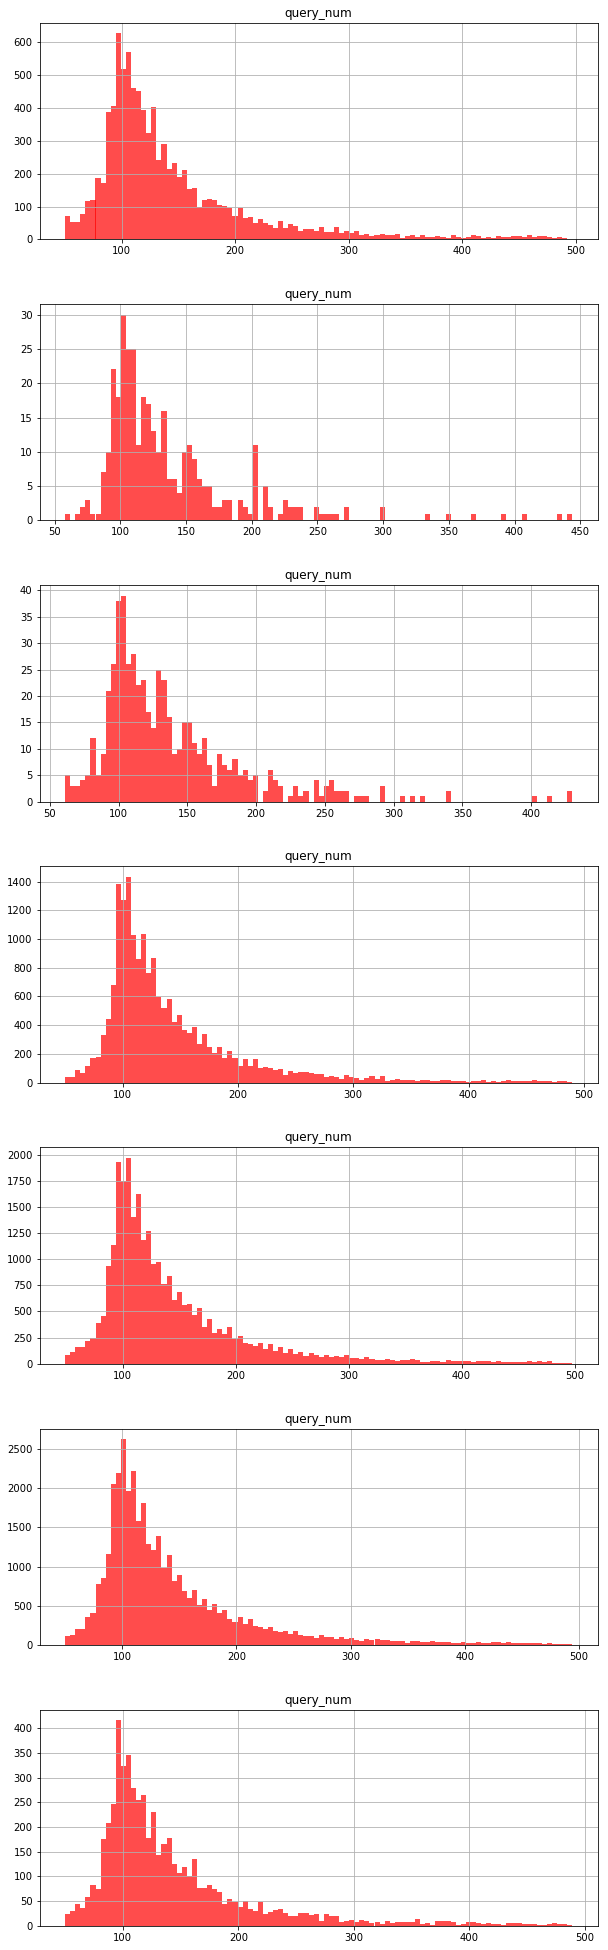

In [29]:
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Education==i].hist('query_num',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

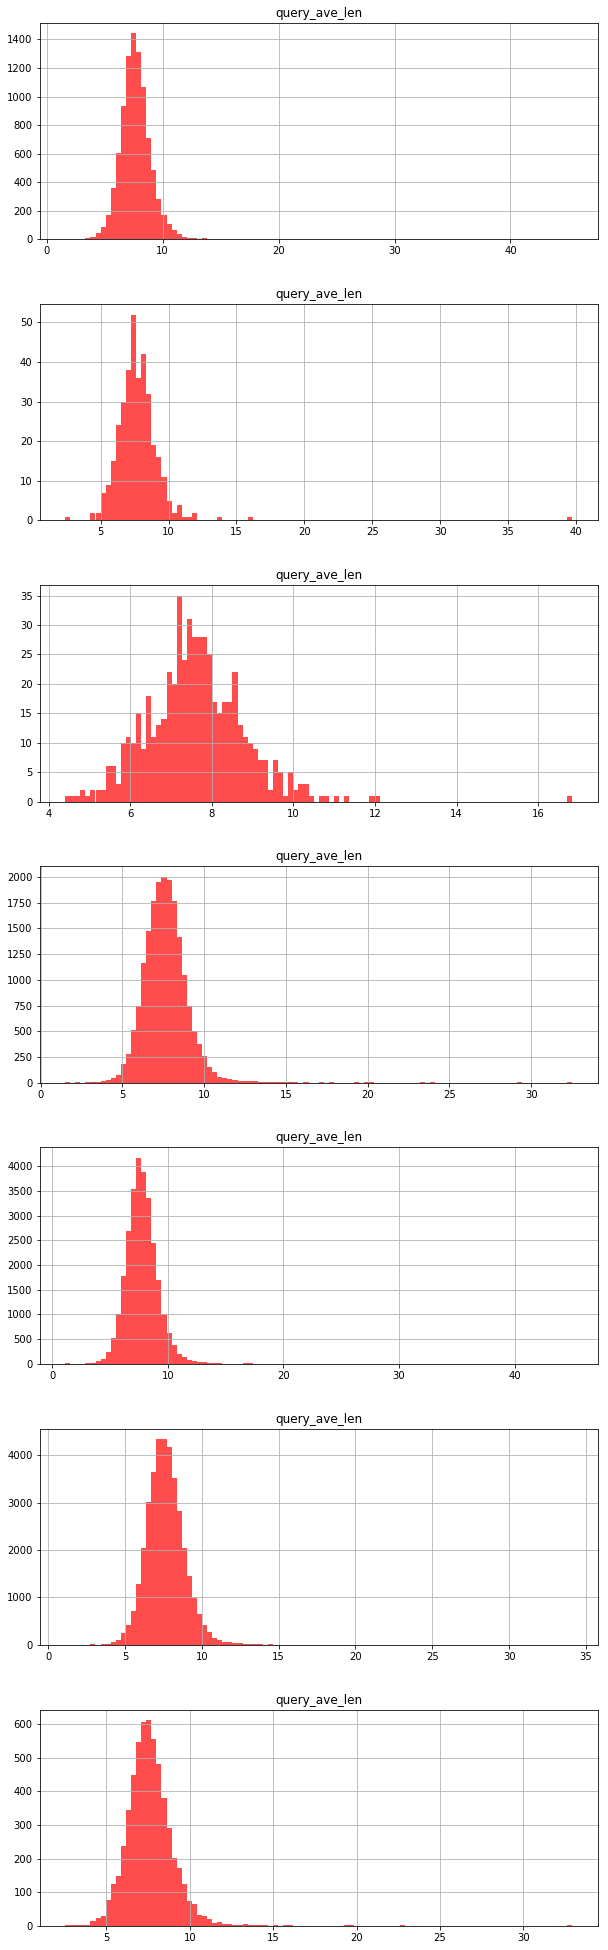

In [30]:
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Education==i].hist('query_ave_len',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

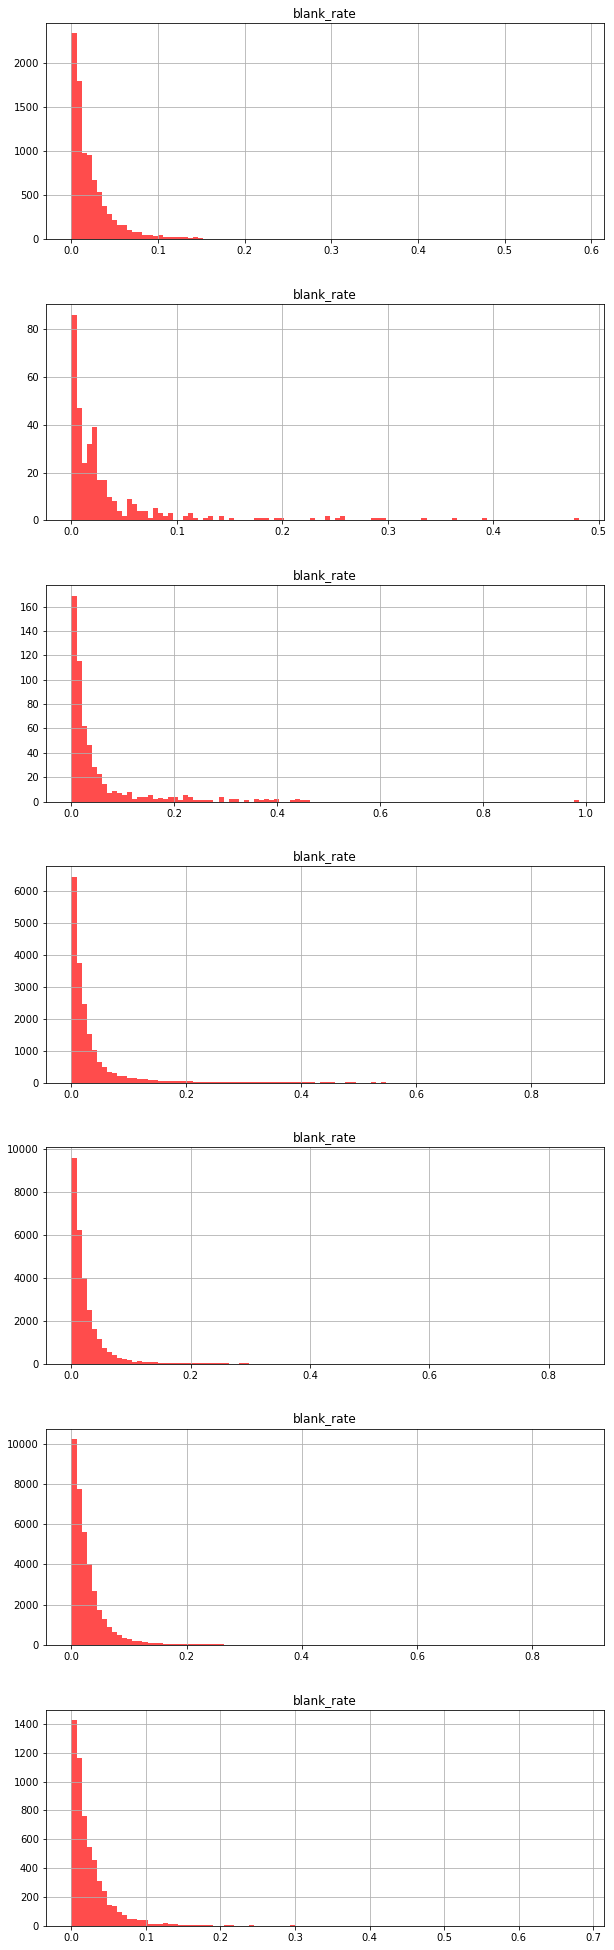

In [31]:
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Education==i].hist('blank_rate',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

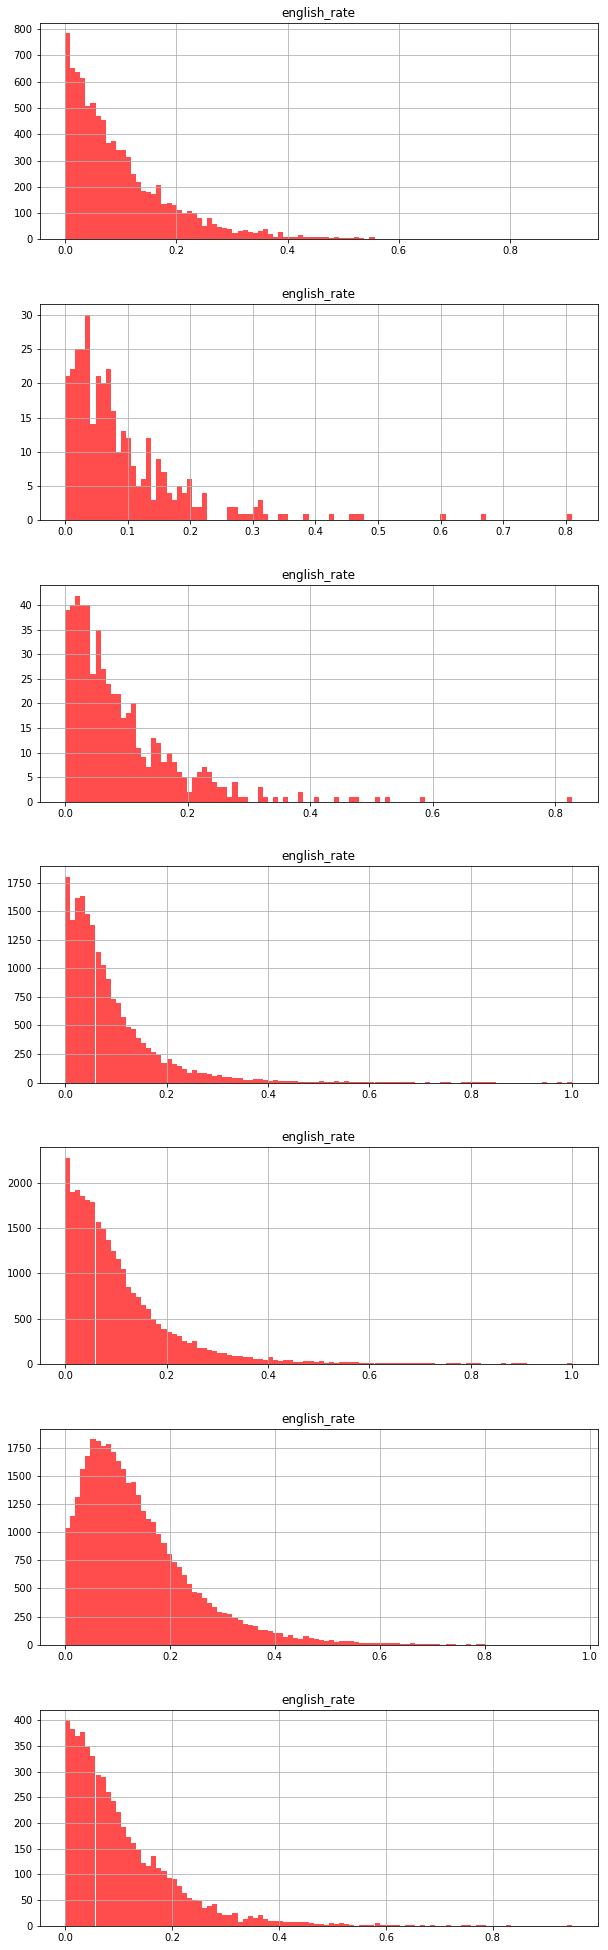

In [33]:
fig,axes = plt.subplots(7,1,figsize=(10,35))
for i in range(7):
    data_df[data_df.Education==i].hist('english_rate',ax=axes[i],bins=100,color='r',alpha=0.7)
#     data_df[data_df.Age==].hist('query_num',bins=100,color='b',alpha=0.7)
plt.show()

#####  特征空格率、字母率数据需做个转化

#### 模型构建和训练

In [2]:
import re

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


class TextClassifier():

    def __init__(self, classifier=MultinomialNB()):
        self.classifier = classifier
        self.vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,4), max_features=20000)

    def features(self, X):
        return self.vectorizer.transform(X)

    def fit(self, X, y):
        self.vectorizer.fit(X)
        self.classifier.fit(self.features(X), y)

    def predict(self, x):
        return self.classifier.predict(self.features([x]))

    def score(self, X, y):
        return self.classifier.score(self.features(X), y)

    def save_model(self, path):
        dump((self.classifier, self.vectorizer), path)

    def load_model(self, path):
        self.classifier, self.vectorizer = load(path)

In [4]:
#重新载入数据
names = ['ID', 'Age', 'Gender', 'Education','age_kfold_index','gender_kfold_index','education_kfold_index', 'Query']
data_df= pd.read_csv('./data/preprocessed.csv',sep=',',header=None,names=names)
#加载停用词
stopwords = pd.read_csv('./data/stopwords.txt',sep='\t',header=None,names=['stopword'],
                        quoting=3,encoding='utf-8',engine='python')
stopword = set(stopwords.stopword.values)

def _process(querys):
    words = []
#     if isinstance(stopwords,set):
#         stopwords = set(stopwords)
    for single_query in querys.split('\t\t'):
        for word in single_query.split('\t'):
            if word in stopword:
                continue
            words.append(word)
    return ' '.join(words)
        
    
    
def generate_train_data(data_df,group_name="Gender",k_fold_attr_name='gender_kfold_index',n=0):
    ''' n=0时 第一折 n=2时第二折 ......'''
    data_df['Query'] = data_df['Query'].progress_apply(lambda x: _process(x))
    data_df =data_df[data_df[group_name]!=0]
    train = data_df[data_df[k_fold_attr_name]!=n]
    train_data = train['Query'].values
    train_label = train[group_name].values
    val = data_df[data_df[k_fold_attr_name]==n]
    val_data = val['Query'].values
    val_label = val[group_name].values
    return train_data,train_label,val_data,val_label

trian_x,train_y,val_x,val_y = generate_train_data(data_df,group_name='Gender',k_fold_attr_name='gender_kfold_index')
print(len(trian_x))
print(len(train_y))
print(len(val_x))
print(len(val_y))
    

apply: 100%|█████████████████████████████████████████████████████████████████| 100000/100000 [00:28<00:00, 3454.19it/s]


78275
78275
19570
19570


In [5]:
print(trian_x[:10])

['广州 厨宝 烤箱 世情 薄 人情 恶 雨送 黄昏 花易落 晓 风干 泪痕 厦门 酒店用品 批发市场 不想 支付 原谅 无情 对不起 处女座 代表 花朵 烤 鸡胸肉 做法   烤箱 忘记 想起 一辈子 长   走 终点 联塑 pvc 排水管 规格 表 大王 椰 性格 文静 250ml 牛奶 克 奶粉 化蝶 寻花   夜夜 栖 芳草 学会 爱   懂得 爱 1001 学会 爱   福睿斯 斗鱼 tv 厨宝 厨宝 烤箱 禹州 城市 广场 电影院 大王 棕树 图片 王 棕树 图片 发酵 箱 6920882798458 不想 支付 原谅 无情 对不起 住 城市 下雨 想 问 带伞   250ml 牛奶 克 奶粉 烤 翅 做法 烤箱 全脂奶粉 泡 比例 牛肉 炒 嫩 厨宝牌 猴配 猴 婚姻 可惜 mv 爱情 公寓 守 不住 笑话 犯 太岁 禹州 城市 广场 电影院 1001 禹州 城市 广场 电影院 烤箱 牌子 全脂奶粉 泡 红 铁人 面粉 蛋白质 含量 走 活成 样子 鸡排 做法 大全 放爱 斗鱼 直播 糖浆 熬 鸡胸肉 烤 沙枣 轮胎 气压 mp1003 轮胎 气压 6933005900560 厨宝 牌子 冰皮 月饼 糯米粉 一辈子 走 永远都是 1992 生肖 猴 配对 处女座 座 配对 1001 处女座 座 世界 爱 冒险 自欺欺人 虎牙 直播 想像 爱 1006 5000 瓦一 小时 多少度 电 鸡排 做法 大全 好吃 卡农 故事 陌上 花开 缓缓 爱 不用 道歉 首歌 名 这场 婚礼 足够 1001 这场 婚礼 厨宝 人生 如初   何事 秋风 悲画 扇 hiv 耳朵 图 图 图片 空间 发 视频 发 普洁 厨宝 官网 一辈子 长   走 终点 1001 一辈子 生肖 猴 配对 高筋 面粉 做 吃 杨之华 林肯 处女座 男生 感情 爱 有恃无恐 紫罗兰 学会 爱   懂得 爱 王棕 龟头 小红点 烤鸡肉 做法   烤箱 邓超 明 少 香菇 鸡片 做法 5000 瓦一 小时 多少度 电 1001 5000 瓦一 小时 黄油 1688 阿里巴巴 批发网 和面机 茉香 绿茶 泡法 意大利 烟肉 厨宝 说 说 漫漫 人生路 一句 冰皮 月饼 做法 配方 分手 追 6909640000644 可不可以 勇敢 厨宝 烤箱 价格表 处女座 男生 恋爱 鸡胸肉 做法 全家 牛至

In [9]:
text_classifier = TextClassifier()
text_classifier.fit(trian_x, train_y)
print(text_classifier.score(val_x, val_y))

0.8042411854879918


In [11]:
from joblib import dump,load
text_classifier.save_model("./model/model.h5")